In [4]:
#Sktime imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit

from IPython.utils import io
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import seaborn as sns
import time
import joblib
import sys
from os.path import exists

import importlib

#EEG package modules_____________________________________________________________________________

import constants
import custom_ts_length
# import eeg_stat_ts
import format_eeg_data
import run_expts

#Load the appropriate data ________________________________________________________________________
'''
o 1. PD vs HC,   2.(PD , PD+RBD) vs HC,   3.(PD + PD&RBD) vs HC vs RBD  multiclass, 4.PD vs PD+RBD vs RBD vs HC 
'''
core_path = '/export/sphere/ebirah/ko20929/RBD_files/notebooks/frequency_analysis/constructed_data/band_power_time_series/expt_dfs/'
folder = 'REM_full_expts/'
#Load the appropriate X (full set of features ) , y (full set of labels) , groups 
load_path = core_path + folder
X = pd.read_hdf(load_path + 'X.h5', key='df', mode='r')
y = pd.read_hdf(load_path + 'y_full.h5', key='df', mode='r') 
groups = pd.read_hdf(load_path + 'groups.h5', key='df', mode='r')  

#### Define X_subset

In [5]:
X_subset = X.iloc[:, :7]

for structure , name in zip([X_subset, y , groups] , ['X', 'y', 'groups']): 
    print(name)
    print( 'There are ' + str(len(structure) ) + ' samples')
    print( 'There are ' + str(len(np.unique(structure.index))) + ' unique samples' ) 

y.value_counts()

X
There are 69 samples
There are 69 unique samples
y
There are 69 samples
There are 69 unique samples
groups
There are 69 samples
There are 69 unique samples


0    26
3    22
1    14
2     7
Name: y_label, dtype: int64

### Previously used Group Shuffle Split

In [8]:
69*0.2

13.8

In [12]:
#The test function
gss = GroupShuffleSplit(n_splits=5, test_size = 0.2,  random_state=13)

test_samples = []
test_indices = []
test_groups = []

for train_index, test_index  in gss.split(X_subset, y, groups):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                test_group = groups.iloc[test_index]
                test_groups.append(test_group)
                test_indices.append(test_index)
                
                print(str(len(train_index)) + ' ' + str(len(test_index) ))

print(np.sort(np.concatenate(test_indices)) )
print(len(np.concatenate(test_indices)) )

55 14
53 16
55 14
57 12
54 15
[ 0  1  5  5  6  6  7  8  9  9 10 10 11 11 12 12 13 13 17 18 18 19 19 20
 21 22 22 23 23 26 27 28 29 30 31 32 33 33 34 35 35 36 36 40 41 42 42 43
 43 44 44 45 48 49 51 51 52 52 53 54 54 54 55 55 57 58 61 62 62 67 68]
71


### Using Group k-fold instead edit : This works! ... 

In [14]:
X_subset.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34,
       35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70,
       71])

In [79]:
 np. random. get_state()[1][0]

3

In [ ]:
#Check out stratified Kfold

In [77]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits = 5) 

test_splits = []
test_indices = []

np.random.seed(3)

for train, test in gkf.split(X_subset ,y, groups = groups.astype(int)*-1):
    test_splits.append(test)
    test_set = X_subset.iloc[test]
    test_indices.append( np.sort(test_set.index.values) )
    
len(np.sort(np.concatenate(test_splits) ) )

test_indices

[array([ 3,  4,  7,  8, 17, 29, 30, 35, 39, 40, 41, 48, 65, 71]),
 array([ 0,  1,  5,  6, 11, 12, 14, 27, 28, 34, 42, 43, 47, 56]),
 array([13, 15, 16, 20, 21, 24, 25, 26, 46, 50, 51, 57, 66, 67]),
 array([ 2, 18, 19, 23, 37, 53, 54, 58, 59, 60, 63, 68, 69, 70]),
 array([ 9, 10, 22, 31, 32, 36, 44, 45, 49, 52, 55, 61, 62])]

In [51]:
test_indices_before_seed_edit

[array([ 9, 10, 18, 19, 22, 39, 40, 41, 47, 56, 59, 60, 63, 67]),
 array([ 0,  1, 29, 30, 31, 32, 34, 46, 53, 54, 55, 61, 62, 66]),
 array([ 7,  8, 13, 15, 16, 23, 35, 36, 42, 43, 52, 65, 68, 69]),
 array([ 2,  5,  6, 11, 12, 14, 27, 28, 37, 44, 45, 49, 58, 71]),
 array([ 3,  4, 17, 20, 21, 24, 25, 26, 48, 50, 51, 57, 70])]

In [43]:
test_indices_list

[array([ 3,  4,  7,  8, 17, 29, 30, 35, 39, 40, 41, 48, 65, 71]),
 array([ 0,  1,  5,  6, 11, 12, 14, 27, 28, 34, 42, 43, 47, 56]),
 array([13, 15, 16, 20, 21, 24, 25, 26, 46, 50, 51, 57, 66, 67]),
 array([ 2, 18, 19, 23, 37, 53, 54, 58, 59, 60, 63, 68, 69, 70]),
 array([ 9, 10, 22, 31, 32, 36, 44, 45, 49, 52, 55, 61, 62])]

In [61]:
#Join y and groups to the features dataframe 'X' 
#Shuffle the dataframe - with random_state = something 
#Re-define , y and groups from the dataframe 
#Drop y and groups from the dataframe 
#Do the split

X_subset_new = X_subset.copy()
X_subset_new['y'] = y.copy()
X_subset_new['groups'] = groups.copy()

X_subset_new = X_subset_new.sample(frac = 1 , random_state  = 1)
groups_new = X_subset_new['groups']
y_new = X_subset_new['y']

#Trying to get a differernt PID SPLIT 
groups_new = groups_new.astype(int)
groups_new = groups_new*-1


X_subset_new = X_subset_new.drop(columns = ['y', 'groups'])

# Do group Kfold on the tinggggggggggggggggggggggggggggggggggggggggggggg
gkf = GroupKFold(n_splits = 5) 

test_splits = []
test_indices_list = []
p_id_list = []

for train, test in gkf.split(X_subset_new ,y_new, groups = groups_new):
    test_splits.append(test)
    test_indices = X_subset_new.iloc[test].index.values
    test_indices_list.append(np.sort(test_indices) )
    p_id_list.append(np.sort(groups_new.iloc[test].values*-1))


In [66]:
def check_duplicates(arrays):
    all_values = set()
    for array in arrays:
        duplicates = set(array) & all_values
        if duplicates:
            return f"Error: Duplicates found in arrays: {duplicates}"
        all_values.update(array)
        
    return "No duplicates found"

In [69]:
check_duplicates(p_id_list)

'Error: Duplicates found in arrays: {1103}'

In [62]:
pd.options.display.max_columns = 40
df_counts = pd.DataFrame(groups.value_counts()[groups.value_counts() > 1] ).T 
df_counts

,2210,1101,1116,4403,2212,2211,4408,4409,2205,2204,2203,4401,1119,1106,1113,1103,1111,3304,1108,1104,1105
part_id,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [63]:
p_id_list

[array([1103, 1103, 1105, 1105, 1112, 2204, 2204, 2207, 2210, 2210, 2210,
        2215, 3301, 3306]),
 array([1101, 1101, 1104, 1104, 1108, 1108, 1110, 2203, 2203, 2206, 2211,
        2211, 2214, 4405]),
 array([1109, 1111, 1111, 1116, 1116, 1119, 1119, 2202, 2213, 3302, 3303,
        4401, 4401, 4406]),
 array([1102, 1113, 1113, 1118, 2209, 3304, 3304, 3305, 4403, 4403, 4407,
        4408, 4408, 4410]),
 array([1106, 1106, 1117, 2205, 2205, 2208, 2212, 2212, 2216, 4402, 4404,
        4409, 4409])]

In [15]:
test

array([ 3,  4, 17, 20, 21, 24, 25, 26, 46, 48, 49, 55, 67])

In [14]:
train

array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19,
       22, 23, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 68])

### I think the issue is here

https://scikit-learn.org/stable/modules/cross_validation.html#group-shuffle-split

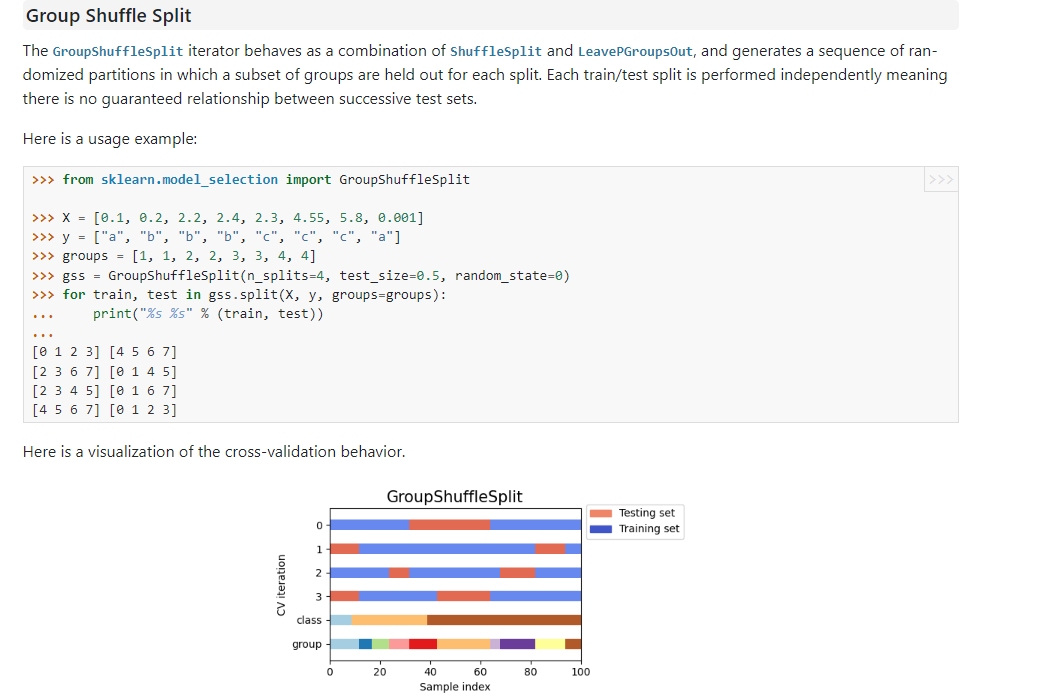